# Bayesian Machine Learning
## Neural networks: SGD

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
class XYDataset(Dataset):

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def __len__(self):
        return len(self.Y)

In [4]:
def test(model, loss_fn, dataloader):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = torch.FloatTensor(X).to(device)
            y = torch.LongTensor(y).to(device)
            pred = model(X)
            test_loss += loss_fn(torch.squeeze(pred), y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    accuracy /= size
    return test_loss, accuracy


In [5]:
def train(model, optimizer, loss_fn, dataloader):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, accuracy = 0, 0
    for X, y in dataloader:
        X = torch.FloatTensor(X).to(device)
        y = torch.LongTensor(y).to(device)
        pred = model(X)
        loss = loss_fn(torch.squeeze(pred), y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    train_loss /= num_batches
    accuracy /= size
    return train_loss, accuracy

In [6]:
def trainer(model, optimizer, loss_fn, train_dataloader, test_dataloader, n_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, n_epochs + 1):
        train_loss, train_accuracy = train(model, optimizer, loss_fn, train_dataloader)
        test_loss, test_accuracy = test(model, loss_fn, test_dataloader)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        if epoch % 10 == 0:
            print(f"[Epoch {epoch} / {n_epochs}] train loss = {train_loss:.2f} acc = {train_accuracy:.2f} ",
                f"test loss = {test_loss:.2f} acc = {test_accuracy:.2f}")

    return (train_losses, train_accuracies), (test_losses, test_accuracies)

In [7]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

### Noisy XOR

[Epoch 10 / 200] train loss = 0.69 acc = 0.54  test loss = 0.69 acc = 0.53
[Epoch 20 / 200] train loss = 0.67 acc = 0.61  test loss = 0.68 acc = 0.60
[Epoch 30 / 200] train loss = 0.65 acc = 0.61  test loss = 0.66 acc = 0.56
[Epoch 40 / 200] train loss = 0.63 acc = 0.65  test loss = 0.63 acc = 0.65
[Epoch 50 / 200] train loss = 0.60 acc = 0.68  test loss = 0.61 acc = 0.63
[Epoch 60 / 200] train loss = 0.56 acc = 0.68  test loss = 0.57 acc = 0.65
[Epoch 70 / 200] train loss = 0.51 acc = 0.77  test loss = 0.51 acc = 0.77
[Epoch 80 / 200] train loss = 0.43 acc = 0.87  test loss = 0.42 acc = 0.89
[Epoch 90 / 200] train loss = 0.35 acc = 0.88  test loss = 0.34 acc = 0.89
[Epoch 100 / 200] train loss = 0.31 acc = 0.88  test loss = 0.30 acc = 0.89
[Epoch 110 / 200] train loss = 0.29 acc = 0.89  test loss = 0.28 acc = 0.89
[Epoch 120 / 200] train loss = 0.28 acc = 0.89  test loss = 0.27 acc = 0.89
[Epoch 130 / 200] train loss = 0.27 acc = 0.89  test loss = 0.27 acc = 0.89
[Epoch 140 / 200] tra

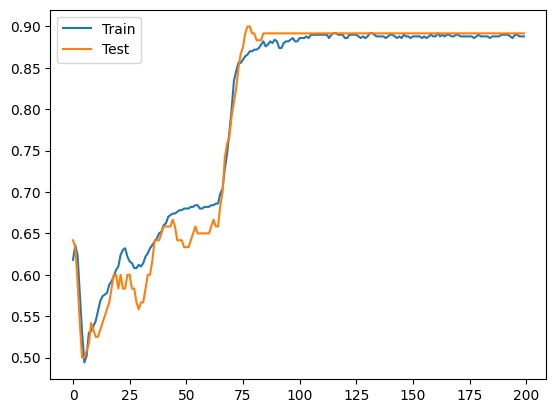

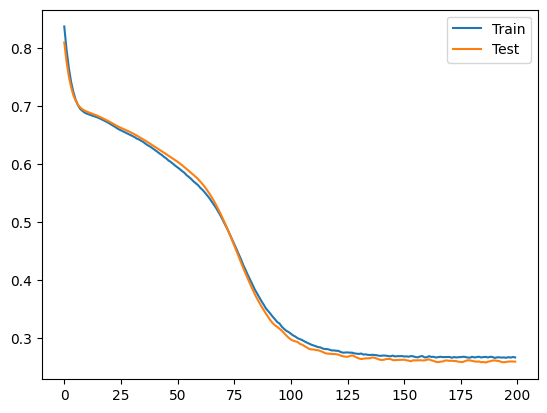

In [8]:
X_noisy_xor_1 = pd.read_csv("../data/noisy_xor/data1/training/x.csv")
Y_noisy_xor_1 = pd.read_csv("../data/noisy_xor/data1/training/y.csv")
X_noisy_xor_1 = X_noisy_xor_1.to_numpy(dtype=np.float32)
Y_noisy_xor_1 = Y_noisy_xor_1.to_numpy(dtype=int).flatten()
X_noisy_xor_1_test = pd.read_csv("../data/noisy_xor/data1/test/x.csv")
Y_noisy_xor_1_test = pd.read_csv("../data/noisy_xor/data1/test/y.csv")
X_noisy_xor_1_test = X_noisy_xor_1_test.to_numpy(dtype=np.float32)
Y_noisy_xor_1_test = Y_noisy_xor_1_test.to_numpy(dtype=int).flatten()

batch_size = 256
train_dataset = XYDataset(X_noisy_xor_1, Y_noisy_xor_1)
test_dataset = XYDataset(X_noisy_xor_1_test, Y_noisy_xor_1_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = nn.Sequential(
    nn.Linear(2, 2),
    nn.ReLU(),
    nn.Linear(2, 2),
    nn.ReLU(),
    nn.Linear(2, 2)
).to(device)
model.apply(weights_init)

lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
loss_fn = nn.CrossEntropyLoss()

n_epochs = 200
(train_losses, train_accuracies), (test_losses, test_accuracies) = trainer(
    model, optimizer, loss_fn, train_dataloader, test_dataloader, n_epochs
)

plt.figure()
plt.plot(train_accuracies, label="Train")
plt.plot(test_accuracies, label="Test")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.show()

[Epoch 10 / 200] train loss = 0.64 acc = 0.74  test loss = 0.63 acc = 0.74
[Epoch 20 / 200] train loss = 0.51 acc = 0.83  test loss = 0.50 acc = 0.84
[Epoch 30 / 200] train loss = 0.40 acc = 0.86  test loss = 0.40 acc = 0.86
[Epoch 40 / 200] train loss = 0.35 acc = 0.87  test loss = 0.35 acc = 0.87
[Epoch 50 / 200] train loss = 0.32 acc = 0.87  test loss = 0.32 acc = 0.87
[Epoch 60 / 200] train loss = 0.31 acc = 0.87  test loss = 0.31 acc = 0.87
[Epoch 70 / 200] train loss = 0.30 acc = 0.87  test loss = 0.30 acc = 0.87
[Epoch 80 / 200] train loss = 0.30 acc = 0.87  test loss = 0.29 acc = 0.87
[Epoch 90 / 200] train loss = 0.29 acc = 0.87  test loss = 0.29 acc = 0.87
[Epoch 100 / 200] train loss = 0.29 acc = 0.87  test loss = 0.29 acc = 0.87
[Epoch 110 / 200] train loss = 0.29 acc = 0.87  test loss = 0.29 acc = 0.87
[Epoch 120 / 200] train loss = 0.29 acc = 0.87  test loss = 0.29 acc = 0.87
[Epoch 130 / 200] train loss = 0.29 acc = 0.87  test loss = 0.29 acc = 0.87
[Epoch 140 / 200] tra

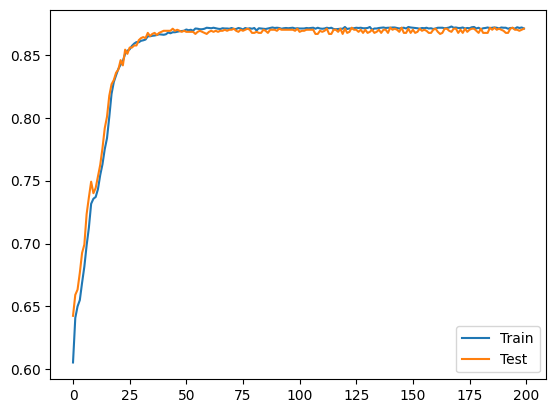

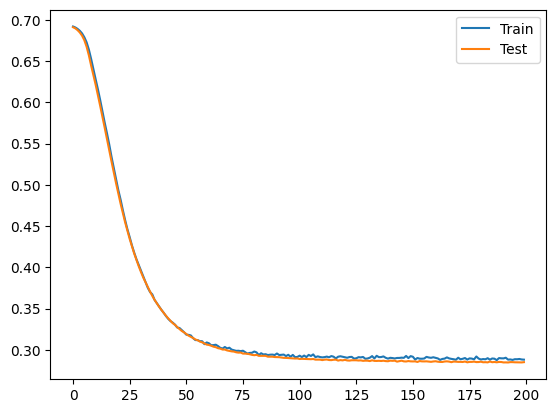

In [9]:
X_noisy_xor_2 = pd.read_csv("../data/noisy_xor/data2/training/x.csv")
Y_noisy_xor_2 = pd.read_csv("../data/noisy_xor/data2/training/y.csv")
X_noisy_xor_2 = X_noisy_xor_2.to_numpy(dtype=np.float32)
Y_noisy_xor_2 = Y_noisy_xor_2.to_numpy(dtype=int).flatten()
X_noisy_xor_2_test = pd.read_csv("../data/noisy_xor/data2/test/x.csv")
Y_noisy_xor_2_test = pd.read_csv("../data/noisy_xor/data2/test/y.csv")
X_noisy_xor_2_test = X_noisy_xor_2_test.to_numpy(dtype=np.float32)
Y_noisy_xor_2_test = Y_noisy_xor_2_test.to_numpy(dtype=int).flatten()

batch_size = 256
train_dataset = XYDataset(X_noisy_xor_2, Y_noisy_xor_2)
test_dataset = XYDataset(X_noisy_xor_2_test, Y_noisy_xor_2_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = nn.Sequential(
    nn.Linear(2, 2),
    nn.ReLU(),
    nn.Linear(2, 2),
    nn.ReLU(),
    nn.Linear(2, 2)
).to(device)
model.apply(weights_init)

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
loss_fn = nn.CrossEntropyLoss()

n_epochs = 200
(train_losses, train_accuracies), (test_losses, test_accuracies) = trainer(
    model, optimizer, loss_fn, train_dataloader, test_dataloader, n_epochs
)

plt.figure()
plt.plot(train_accuracies, label="Train")
plt.plot(test_accuracies, label="Test")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.show()

### Pima

[Epoch 10 / 200] train loss = 2.81 acc = 0.57  test loss = 2.44 acc = 0.66
[Epoch 20 / 200] train loss = 1.17 acc = 0.52  test loss = 1.12 acc = 0.51
[Epoch 30 / 200] train loss = 0.85 acc = 0.45  test loss = 0.86 acc = 0.47
[Epoch 40 / 200] train loss = 0.74 acc = 0.44  test loss = 0.76 acc = 0.48
[Epoch 50 / 200] train loss = 0.70 acc = 0.50  test loss = 0.70 acc = 0.52
[Epoch 60 / 200] train loss = 0.68 acc = 0.64  test loss = 0.67 acc = 0.71
[Epoch 70 / 200] train loss = 0.66 acc = 0.64  test loss = 0.65 acc = 0.71
[Epoch 80 / 200] train loss = 0.66 acc = 0.64  test loss = 0.63 acc = 0.71
[Epoch 90 / 200] train loss = 0.65 acc = 0.64  test loss = 0.63 acc = 0.71
[Epoch 100 / 200] train loss = 0.65 acc = 0.64  test loss = 0.62 acc = 0.71
[Epoch 110 / 200] train loss = 0.65 acc = 0.64  test loss = 0.62 acc = 0.71
[Epoch 120 / 200] train loss = 0.65 acc = 0.64  test loss = 0.61 acc = 0.71
[Epoch 130 / 200] train loss = 0.65 acc = 0.64  test loss = 0.61 acc = 0.71
[Epoch 140 / 200] tra

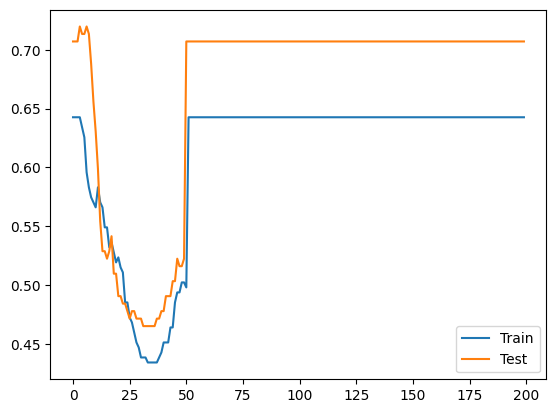

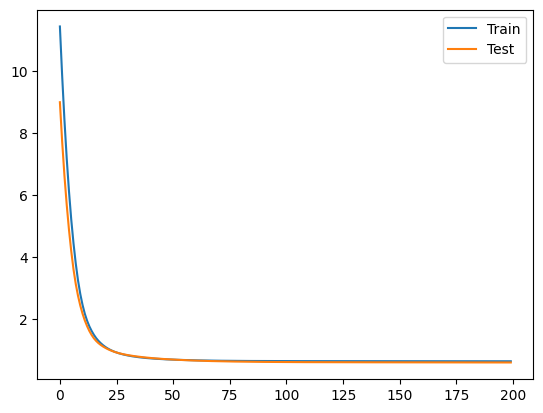

In [37]:
X_pima_1 = pd.read_csv("../data/pima/data1/x.csv")
Y_pima_1 = pd.read_csv("../data/pima/data1/y.csv")
X_pima_1 = X_pima_1.to_numpy(dtype=np.float32)
Y_pima_1 = Y_pima_1.to_numpy(dtype=int).flatten()

X_train, X_test, y_train, y_test = train_test_split(X_pima_1, Y_pima_1, test_size=0.4)

batch_size = 256
train_dataset = XYDataset(X_train, y_train)
test_dataset = XYDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = nn.Sequential(
    nn.Linear(8, 2),
    nn.ReLU(),
    nn.Linear(2, 2),
    nn.ReLU(),
    nn.Linear(2, 2),
    nn.ReLU(),
    nn.Linear(2, 2),
).to(device)
model.apply(weights_init)

lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
loss_fn = nn.CrossEntropyLoss()

n_epochs = 200
(train_losses, train_accuracies), (test_losses, test_accuracies) = trainer(
    model, optimizer, loss_fn, train_dataloader, test_dataloader, n_epochs
)

plt.figure()
plt.plot(train_accuracies, label="Train")
plt.plot(test_accuracies, label="Test")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.show()

[Epoch 10 / 200] train loss = 0.65 acc = 0.65  test loss = 0.64 acc = 0.66
[Epoch 20 / 200] train loss = 0.65 acc = 0.65  test loss = 0.64 acc = 0.66
[Epoch 30 / 200] train loss = 0.66 acc = 0.65  test loss = 0.64 acc = 0.66
[Epoch 40 / 200] train loss = 0.66 acc = 0.65  test loss = 0.64 acc = 0.66
[Epoch 50 / 200] train loss = 0.65 acc = 0.65  test loss = 0.64 acc = 0.66
[Epoch 60 / 200] train loss = 0.65 acc = 0.65  test loss = 0.64 acc = 0.66
[Epoch 70 / 200] train loss = 0.64 acc = 0.65  test loss = 0.64 acc = 0.66
[Epoch 80 / 200] train loss = 0.66 acc = 0.65  test loss = 0.64 acc = 0.66
[Epoch 90 / 200] train loss = 0.64 acc = 0.65  test loss = 0.64 acc = 0.66
[Epoch 100 / 200] train loss = 0.65 acc = 0.65  test loss = 0.64 acc = 0.66
[Epoch 110 / 200] train loss = 0.65 acc = 0.65  test loss = 0.64 acc = 0.66
[Epoch 120 / 200] train loss = 0.65 acc = 0.65  test loss = 0.64 acc = 0.66
[Epoch 130 / 200] train loss = 0.65 acc = 0.65  test loss = 0.64 acc = 0.66
[Epoch 140 / 200] tra

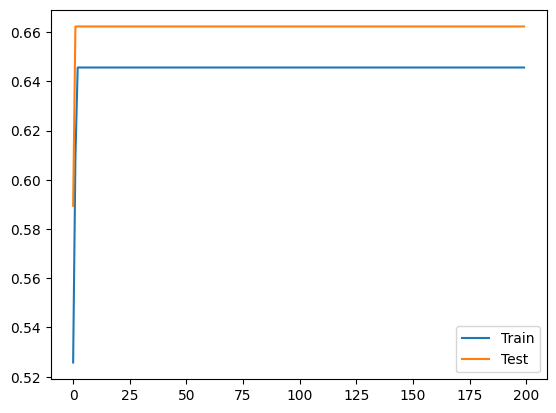

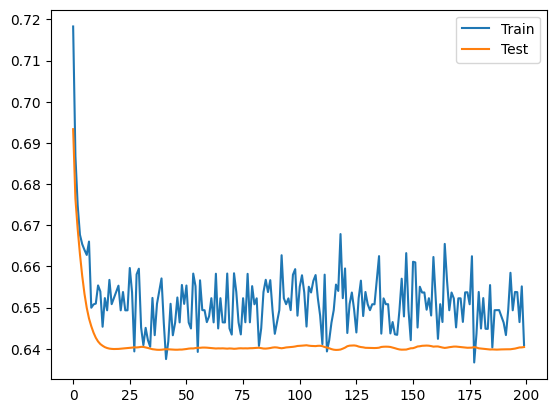

In [38]:
X_pima_2 = pd.read_csv("../data/pima/data2/x.csv")
Y_pima_2 = pd.read_csv("../data/pima/data2/y.csv")
X_pima_2 = X_pima_2.to_numpy(dtype=np.float32)
Y_pima_2 = Y_pima_2.to_numpy(dtype=int).flatten()

X_train, X_test, y_train, y_test = train_test_split(X_pima_2, Y_pima_2, test_size=0.2)

batch_size = 256
train_dataset = XYDataset(X_train, y_train)
test_dataset = XYDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = nn.Sequential(
    nn.Linear(4, 2),
    nn.ReLU(),
    nn.Linear(2, 2),
    nn.ReLU(),
    nn.Linear(2, 2),
    nn.ReLU(),
    nn.Linear(2, 2),
).to(device)
model.apply(weights_init)

lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
loss_fn = nn.CrossEntropyLoss()

n_epochs = 200
(train_losses, train_accuracies), (test_losses, test_accuracies) = trainer(
    model, optimizer, loss_fn, train_dataloader, test_dataloader, n_epochs
)

plt.figure()
plt.plot(train_accuracies, label="Train")
plt.plot(test_accuracies, label="Test")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.show()

### Penguins

[Epoch 10 / 200] train loss = 1.11 acc = 0.35  test loss = 1.07 acc = 0.49
[Epoch 20 / 200] train loss = 1.05 acc = 0.45  test loss = 1.06 acc = 0.40
[Epoch 30 / 200] train loss = 1.03 acc = 0.45  test loss = 1.06 acc = 0.40
[Epoch 40 / 200] train loss = 1.05 acc = 0.45  test loss = 1.05 acc = 0.40
[Epoch 50 / 200] train loss = 1.04 acc = 0.45  test loss = 1.05 acc = 0.40
[Epoch 60 / 200] train loss = 1.00 acc = 0.45  test loss = 1.05 acc = 0.40
[Epoch 70 / 200] train loss = 1.00 acc = 0.45  test loss = 1.04 acc = 0.40
[Epoch 80 / 200] train loss = 0.98 acc = 0.73  test loss = 1.03 acc = 0.70
[Epoch 90 / 200] train loss = 0.93 acc = 0.64  test loss = 1.02 acc = 0.66
[Epoch 100 / 200] train loss = 1.03 acc = 0.59  test loss = 1.02 acc = 0.51
[Epoch 110 / 200] train loss = 0.98 acc = 0.73  test loss = 1.00 acc = 0.69
[Epoch 120 / 200] train loss = 0.95 acc = 0.68  test loss = 0.99 acc = 0.69
[Epoch 130 / 200] train loss = 0.98 acc = 0.68  test loss = 0.99 acc = 0.61
[Epoch 140 / 200] tra

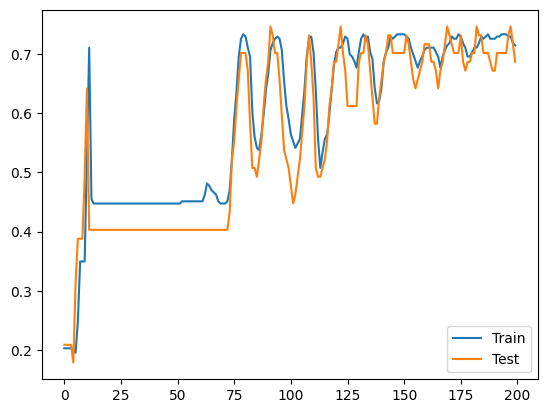

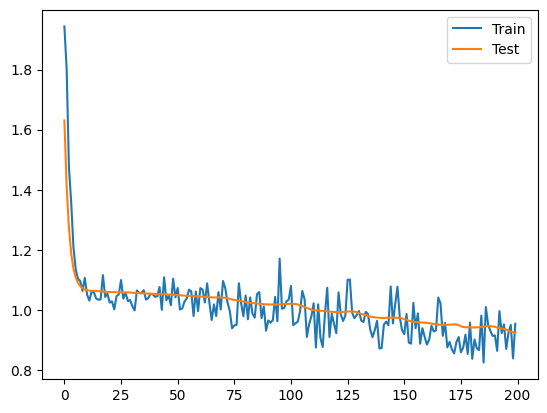

In [56]:
X_penguins = pd.read_csv("../data/penguins/x.csv")
X_penguins.drop(columns="year", inplace=True)
Y_penguins = pd.read_csv("../data/penguins/y.csv")
X_penguins = X_penguins.to_numpy(dtype=np.float32)
Y_penguins = Y_penguins.to_numpy(dtype=int).flatten()

X_train, X_test, y_train, y_test = train_test_split(X_penguins, Y_penguins, test_size=0.2)

batch_size = 256
train_dataset = XYDataset(X_train, y_train)
test_dataset = XYDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = nn.Sequential(
    nn.Linear(6, 2),
    nn.LeakyReLU(),
    nn.Linear(2, 2),
    nn.LeakyReLU(),
    nn.Linear(2, 2),
    nn.LeakyReLU(),
    nn.Linear(2, 3),
).to(device)
model.apply(weights_init)

lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
loss_fn = nn.CrossEntropyLoss()

n_epochs = 200
(train_losses, train_accuracies), (test_losses, test_accuracies) = trainer(
    model, optimizer, loss_fn, train_dataloader, test_dataloader, n_epochs
)

plt.figure()
plt.plot(train_accuracies, label="Train")
plt.plot(test_accuracies, label="Test")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.show()

### Hawks

[Epoch 10 / 200] train loss = 0.96 acc = 0.63  test loss = 0.93 acc = 0.65
[Epoch 20 / 200] train loss = 0.69 acc = 0.63  test loss = 0.66 acc = 0.65
[Epoch 30 / 200] train loss = 0.51 acc = 0.92  test loss = 0.50 acc = 0.91
[Epoch 40 / 200] train loss = 0.40 acc = 0.91  test loss = 0.40 acc = 0.91
[Epoch 50 / 200] train loss = 0.35 acc = 0.92  test loss = 0.36 acc = 0.91
[Epoch 60 / 200] train loss = 0.32 acc = 0.92  test loss = 0.34 acc = 0.91
[Epoch 70 / 200] train loss = 0.30 acc = 0.92  test loss = 0.32 acc = 0.91
[Epoch 80 / 200] train loss = 0.29 acc = 0.92  test loss = 0.31 acc = 0.91
[Epoch 90 / 200] train loss = 0.28 acc = 0.92  test loss = 0.30 acc = 0.91
[Epoch 100 / 200] train loss = 0.27 acc = 0.92  test loss = 0.30 acc = 0.91
[Epoch 110 / 200] train loss = 0.27 acc = 0.92  test loss = 0.29 acc = 0.91
[Epoch 120 / 200] train loss = 0.26 acc = 0.92  test loss = 0.29 acc = 0.91
[Epoch 130 / 200] train loss = 0.26 acc = 0.92  test loss = 0.29 acc = 0.91
[Epoch 140 / 200] tra

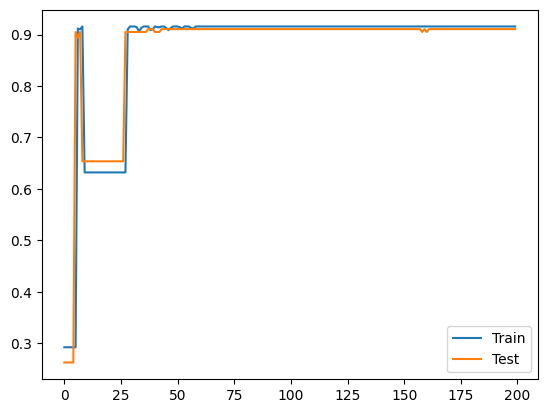

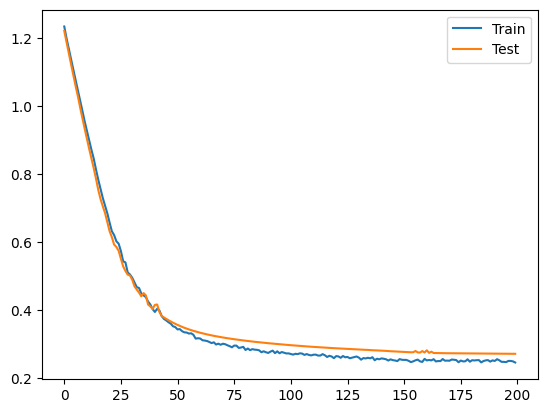

In [13]:
X_hawks = pd.read_csv("../data/hawks/x.csv")
Y_hawks = pd.read_csv("../data/hawks/y.csv")
X_hawks = X_hawks.to_numpy(dtype=np.float32)
Y_hawks = Y_hawks.to_numpy(dtype=int).flatten()

X_train, X_test, y_train, y_test = train_test_split(X_hawks, Y_hawks, test_size=0.2)

batch_size = 256
train_dataset = XYDataset(X_train, y_train)
test_dataset = XYDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = nn.Sequential(
    nn.Linear(6, 2),
    nn.ReLU(),
    nn.Linear(2, 2),
    nn.ReLU(),
    nn.Linear(2, 2),
    nn.ReLU(),
    nn.Linear(2, 3),
).to(device)

lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
loss_fn = nn.CrossEntropyLoss()

n_epochs = 200
(train_losses, train_accuracies), (test_losses, test_accuracies) = trainer(
    model, optimizer, loss_fn, train_dataloader, test_dataloader, n_epochs
)

plt.figure()
plt.plot(train_accuracies, label="Train")
plt.plot(test_accuracies, label="Test")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.show()

### Iris

[Epoch 10 / 200] train loss = 0.88 acc = 0.66  test loss = 0.85 acc = 0.63
[Epoch 20 / 200] train loss = 0.72 acc = 0.69  test loss = 0.70 acc = 0.63
[Epoch 30 / 200] train loss = 0.65 acc = 0.70  test loss = 0.64 acc = 0.67
[Epoch 40 / 200] train loss = 0.61 acc = 0.69  test loss = 0.60 acc = 0.63
[Epoch 50 / 200] train loss = 0.58 acc = 0.68  test loss = 0.58 acc = 0.63
[Epoch 60 / 200] train loss = 0.56 acc = 0.68  test loss = 0.56 acc = 0.63
[Epoch 70 / 200] train loss = 0.54 acc = 0.82  test loss = 0.54 acc = 0.80
[Epoch 80 / 200] train loss = 0.53 acc = 0.87  test loss = 0.53 acc = 0.83
[Epoch 90 / 200] train loss = 0.51 acc = 0.93  test loss = 0.51 acc = 0.93
[Epoch 100 / 200] train loss = 0.50 acc = 0.93  test loss = 0.50 acc = 0.93
[Epoch 110 / 200] train loss = 0.48 acc = 0.93  test loss = 0.47 acc = 0.93
[Epoch 120 / 200] train loss = 0.45 acc = 0.93  test loss = 0.44 acc = 0.93
[Epoch 130 / 200] train loss = 0.40 acc = 0.95  test loss = 0.40 acc = 0.97
[Epoch 140 / 200] tra

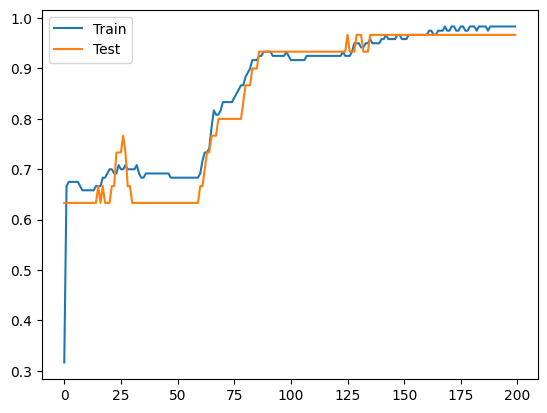

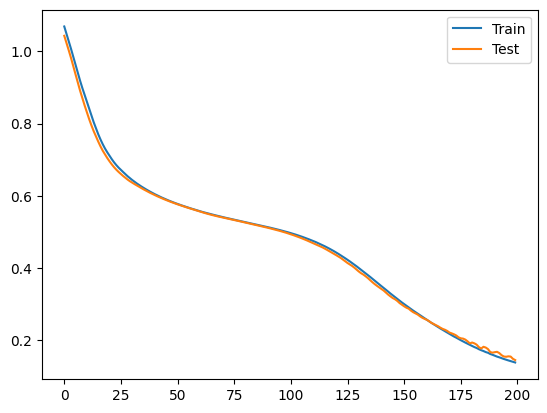

In [22]:
from sklearn.datasets import load_iris

X_iris, Y_iris = load_iris(return_X_y=True)
X_iris = np.array(X_iris, dtype=np.float32)
Y_iris = np.array(Y_iris, dtype=int)
X_train, X_test, y_train, y_test = train_test_split(X_iris, Y_iris, test_size=0.2)

batch_size = 256
train_dataset = XYDataset(X_train, y_train)
test_dataset = XYDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = nn.Sequential(
    nn.Linear(4, 2),
    nn.ReLU(),
    nn.Linear(2, 2),
    nn.ReLU(),
    nn.Linear(2, 2),
    nn.ReLU(),
    nn.Linear(2, 3),
).to(device)
model.apply(weights_init)

lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
loss_fn = nn.CrossEntropyLoss()

n_epochs = 200
(train_losses, train_accuracies), (test_losses, test_accuracies) = trainer(
    model, optimizer, loss_fn, train_dataloader, test_dataloader, n_epochs
)

plt.figure()
plt.plot(train_accuracies, label="Train")
plt.plot(test_accuracies, label="Test")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.legend()
plt.show()